# Performance testing

This notebook demonstrates how much speed-up we can leverage from JAX's JIT (Just-In-Time) compilation.

We compare training on our environment with and without JIT compilation over different number of timesteps and plot the trends.

## How does JIT compilation speed up RL training?

1. **Tracing:**  
   When `jax.jit` is applied to `agent.train`, it records all JAX operations in the function, creating a static computation graph that represents the complete data flow without executing it.

2. **Compilation with XLA:**  
   This graph is sent to XLA (Accelerated Linear Algebra), which optimizes it by fusing operations and eliminating redundancies. XLA then converts the graph into low-level machine code tailored for your hardware (e.g., GPU or TPU).

3. **Direct Execution:**  
   Finally, when you call `train_fn(rng)`, the cached machine code is dispatched directly to the hardware via native drivers (like CUDA for GPUs). Inputs are transferred to device memory if necessary, and the code runs without involving the Python interpreter, drastically reducing runtime overhead.

## Training & Profiling methods

In [1]:
%load_ext autoreload
%autoreload 2

from rejax import PPO
from env import NavigationEnv


def create_ppo_agent(total_timesteps: int = 2_000_000):
    # Initialize our environment
    env = NavigationEnv()

    config = {
        # Pass our environment to the agent
        "env": env,
        # Number of timesteps during which the agent will be trained
        "total_timesteps": total_timesteps,
    }

    # Create the training algorithm agent from `rejax` library
    return PPO.create(**config)

In [2]:
import jax
import time

TRAIN_SEED = 13


def benchmark_train_time(total_timesteps: int, use_jit: bool = True):
    # Set training seed and jit train function
    start = time.time()
    agent = create_ppo_agent(total_timesteps)
    rng = jax.random.PRNGKey(TRAIN_SEED)

    train_fn = jax.jit(agent.train) if use_jit else agent.train

    train_fn(rng)
    time_elapsed = time.time() - start

    # Steps per second
    sps = agent.total_timesteps / time_elapsed

    del agent  # Free up memory

    return sps, time_elapsed

## Benchmark (JIT vs No JIT)

In [3]:
total_timesteps_settings = [100_000 * 2**i for i in range(0, 7)]

benchmark_data = []
for ts in total_timesteps_settings:
    for use_jit in [True, False]:
        sps, t_elapsed = benchmark_train_time(ts, use_jit)

        benchmark_data.append({"total_timesteps": ts, "JIT": use_jit, "sps": sps, "time": t_elapsed})
        print(f"Total timesteps: {ts}, JIT: {use_jit}, Speed (steps/s): {sps:.2f}, Time elapsed (s): {t_elapsed:.2f}")

Total timesteps: 100000, JIT: True, Speed (steps/s): 28125.35, Time elapsed (s): 3.56
Total timesteps: 100000, JIT: False, Speed (steps/s): 13246.43, Time elapsed (s): 7.55
Total timesteps: 200000, JIT: True, Speed (steps/s): 49055.54, Time elapsed (s): 4.08
Total timesteps: 200000, JIT: False, Speed (steps/s): 28383.11, Time elapsed (s): 7.05
Total timesteps: 400000, JIT: True, Speed (steps/s): 109658.53, Time elapsed (s): 3.65
Total timesteps: 400000, JIT: False, Speed (steps/s): 25027.23, Time elapsed (s): 15.98
Total timesteps: 800000, JIT: True, Speed (steps/s): 133875.24, Time elapsed (s): 5.98
Total timesteps: 800000, JIT: False, Speed (steps/s): 24697.77, Time elapsed (s): 32.39
Total timesteps: 1600000, JIT: True, Speed (steps/s): 339421.21, Time elapsed (s): 4.71
Total timesteps: 1600000, JIT: False, Speed (steps/s): 29597.81, Time elapsed (s): 54.06
Total timesteps: 3200000, JIT: True, Speed (steps/s): 711366.87, Time elapsed (s): 4.50
Total timesteps: 3200000, JIT: False, S

## Plotting

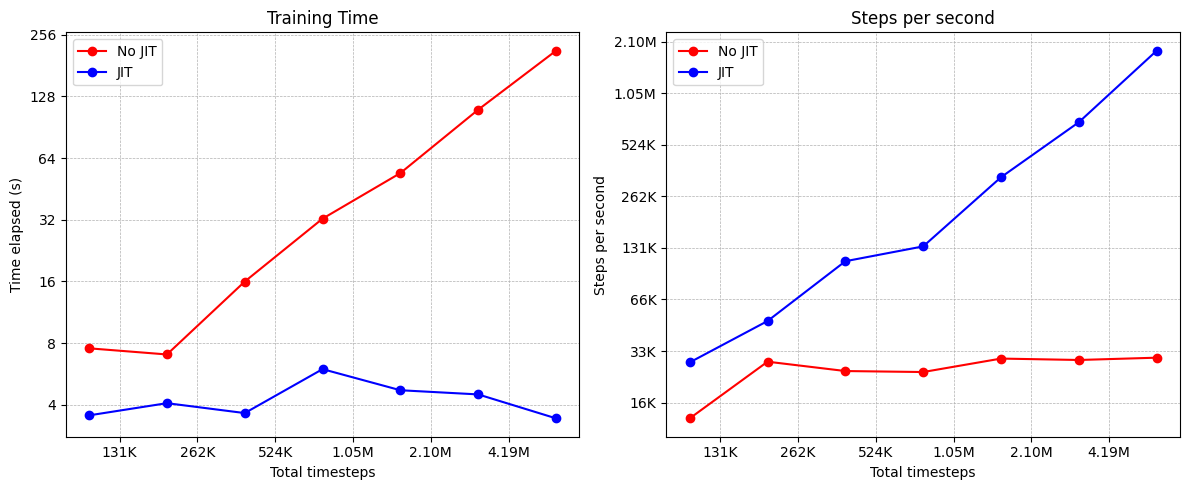

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

df = pd.DataFrame(benchmark_data)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
colors = {True: "b", False: "r"}
labels = {True: "JIT", False: "No JIT"}

for jit, group in df.groupby("JIT"):
    axs[0].plot(
        group["total_timesteps"], group["time"], marker="o", linestyle="-", color=colors[jit], label=labels[jit]
    )
    axs[1].plot(group["total_timesteps"], group["sps"], marker="o", linestyle="-", color=colors[jit], label=labels[jit])


def formatter(x, pos):
    if x < 1_000:
        return f"{x:.0f}"
    elif x < 1_000_000:
        return f"{x / 1000:.0f}K"
    else:
        return f"{x / 1_000_000:.2f}M"


formatter = ticker.FuncFormatter(formatter)

for ax, y_label, title in zip(axs, ["Time elapsed (s)", "Steps per second"], ["Training Time", "Steps per second"]):
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    ax.set_xlabel("Total timesteps")
    ax.set_ylabel(f"{y_label}")
    ax.set_title(title)
    ax.grid(True, which="both", linestyle="--", linewidth=0.5)
    ax.minorticks_on()
    ax.legend()
    ax.xaxis.set_major_formatter(formatter)
    ax.yaxis.set_major_formatter(formatter)


plt.tight_layout()
plt.show()